In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import os
import matplotlib.pyplot as plt
import random
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from datasets import load_dataset

from transformers import BertTokenizerFast, AutoConfig, AutoModel, AutoTokenizer
from transformers import BertConfig
from diffusers import DDIMScheduler
from model.model import AutoEncoder

from create_config import create_config
from estimation_utils.util import clear_text

os.environ['TOKENIZERS_PARALLELISM'] = 'false'
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [18]:
class CondLatentDataset:
    def __init__(self, split, label=None, dataset='qqp', latent=True):
        dataset_label_map = {
            'qqp': ['src', 'trg']
        }
        base_path = f'/home/amshabalin/TextDiffusion/datasets/{dataset}'
        labels = dataset_label_map[dataset]
        if label is not None:
            if isinstance(label, int):
                labels = [labels[label]]
            else:
                labels = [label]

        if latent:
            self.latents = dict()
            for label in labels:
                self.latents[label] = torch.load(f'{base_path}/{split}/bert_{label}.pt')
        else:
            self.latents = None
            
        self.texts = dict()
        for label in labels:
            with open(f'{base_path}/{split}/data.json', 'r') as f:
                self.texts[label] = []
                for line in f:
                    self.texts[label].append(eval(line)[label])

        if self.latents is not None:
            assert len(self.latents[labels[0]]) == len(self.texts[labels[0]])   
                
    def __getitem__(self, idx):
        item = {'text': {'src': self.texts['src'][idx], 'trg': self.texts['trg'][idx]}}
        if self.latents is not None:
            item['latent'] = {'src': self.latents['src'][idx], 'trg': self.latents['trg'][idx]}

        return item

    def __len__(self):
        return len(self.texts['trg'])

In [19]:
N_TOKENS = 50
max_length = 50
dataset = 'qqp'

# train_dataset = CondLatentDataset('train', dataset=dataset, latent=True)
# test_dataset = CondLatentDataset('test', dataset=dataset, latent=True)

In [6]:
config = create_config()
config.bert_config.use_self_cond = config.use_self_cond
config.bert_config.is_decoder = True
config.bert_config.num_hidden_layers = 6

In [7]:
os.environ["RANK"] = '0'
os.environ["WORLD_SIZE"] = '1'
os.environ["MASTER_ADDR"] = '127.0.0.1'
os.environ["MASTER_PORT"] = '32131'

In [8]:
# torch.cuda.set_device(0)
torch.distributed.init_process_group(backend='nccl', init_method='env://', world_size=1, rank=0)

In [11]:
config.checkpoints_prefix = 'qqp--t5-bert-cond_cfg_1751154_150000_'
config.decoder_path = '/home/amshabalin/SlavaDiffusion/models/qqp_3l_transformer_0.15x_t_noise.pt'

In [20]:
from diffusion_holder import DiffusionRunner

config.local_rank = 0
diffusion = DiffusionRunner(config, latent_mode=config.model.embeddings_type, eval=True, log_wandb=False)

Some weights of T5EncoderModel were not initialized from the model checkpoint at t5-base and are newly initialized: ['enc_normalizer.enc_std', 'enc_normalizer.enc_mean']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dataset tokenization (num_proc=30):   0%|          | 0/2500 [00:00<?, ? examples/s]

In [21]:
# diffusion.config.validation.batch_size = 1024
diffusion.set_valid_data_generator()

In [22]:
len(diffusion.valid_loader.dataset)

2500

In [14]:
batch = next(iter(diffusion.valid_loader))

In [15]:
batch.keys()

dict_keys(['input_ids', 'cond_ids', 'input_mask', 'cond_mask', 'input_latent'])

In [23]:
from diffusion_utils import schedulers

sde_scheduler = schedulers.CosineSD(d=10)

In [24]:
ts = torch.linspace(0, 1, 1000).unsqueeze(1)
sqrt_alpha_cumprod = []
for t in ts:
    alpha, _ = sde_scheduler.params(t)
    sqrt_alpha_cumprod.append(alpha.item())

In [25]:
alpha_cumprod = np.array(sqrt_alpha_cumprod)**2
alphas = alpha_cumprod[1:] / alpha_cumprod[:-1]
alphas = np.concatenate((np.array([alphas[0] + 1e-4]), alphas))
alphas.shape

(1000,)

In [19]:
mus = [diffusion.dynamic.marginal_params(torch.tensor([t]))['mu'].item() for t in np.linspace(0, 1, 1000)]

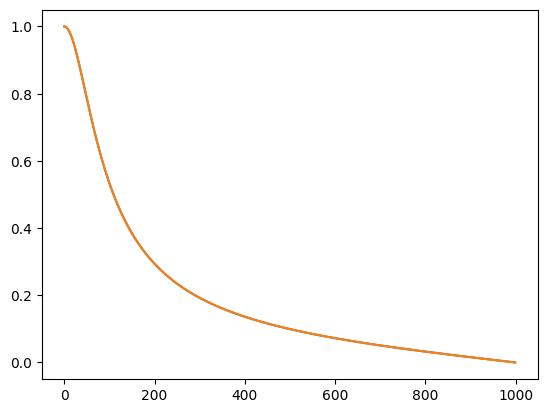

In [20]:
plt.plot(sqrt_alpha_cumprod)
plt.plot(mus)

In [26]:
noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02,
    beta_schedule= "linear",
    trained_betas=1 - alphas,
    clip_sample=False,
    # prediction_type="epsilon"
    prediction_type="sample",
)

In [27]:
from transformers import AutoModelForSequenceClassification, GPT2Tokenizer, GPT2LMHeadModel
from transformers import BloomTokenizerFast, BloomForCausalLM

class GPTMetric:
    def __init__(self, device="cpu"):
        self.name = "gpt2-large"
        self.model = GPT2LMHeadModel.from_pretrained(self.name).eval().to(device)
        self.tokenizer = GPT2Tokenizer.from_pretrained(self.name)
        self.device = device

    @torch.no_grad()
    def __call__(self, text, reduce="mean"):
        inputs = self.tokenizer(text, return_tensors="pt")
        for k, v in inputs.items():
            inputs[k] = v.to(device)

        loss = self.model(**inputs, labels=inputs["input_ids"]).loss.detach().cpu()
        num_tokens = torch.sum(inputs["attention_mask"]).item()
        if reduce == "sum":
            return loss.item() * num_tokens, num_tokens
        return loss.item(), num_tokens


class BloomMetric:
    def __init__(self, device="cpu"):
        self.name = "bigscience/bloom-7b1"
        self.model = BloomForCausalLM.from_pretrained(self.name).eval().to(device)
        self.tokenizer = BloomTokenizerFast.from_pretrained(self.name)
        self.device = device

    @torch.no_grad()
    @torch.autocast(device_type='cuda', dtype=torch.float16)
    def __call__(self, text, reduce="mean"):
        if not text:
            return 0, 0
        inputs = self.tokenizer(text, return_tensors="pt")
        for k, v in inputs.items():
            inputs[k] = v.to(device)

        loss = self.model(**inputs, labels=inputs["input_ids"]).loss.detach().cpu()
        num_tokens = torch.sum(inputs["attention_mask"]).item() - 1
        if reduce == "sum":
            return loss.item() * num_tokens, num_tokens
        return loss.item(), num_tokens


def compute_bloom(texts, bloom):
    num_tokens = 0.0
    metric = 0.0
    for text in texts:
        if len(text) == 0:
            continue
        t_metric, t_num = bloom(text, reduce="sum")
        if t_metric is None or np.isnan(t_metric):
            continue
        metric += t_metric
        num_tokens += t_num
    return round(np.exp(metric / num_tokens), 2), round(metric / num_tokens, 2)

In [21]:
gpt_metric = GPTMetric(device)

In [49]:
# bloom_metric = BloomMetric(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [28]:
from evaluate import load

mauve = load('/home/amshabalin/.cache/huggingface/metrics/mauve')
rouge = load('/home/amshabalin/.cache/huggingface/metrics/rouge')

In [29]:
bertscore = load("/home/amshabalin/.cache/huggingface/metrics/bert_score/bertscore.py")

In [30]:
diffusion.dynamic.N = 20

In [31]:
@torch.no_grad()
def generate_latens(diffusion, cond=None, n_samples=16, num_inference_steps=100,
                    eta=1, clamp_from=1):
    if cond is not None:
        cond_X = diffusion.encoder_cond(**{"input_ids": cond["cond"], "attention_mask": cond["cond_mask"]})
        cond_mask = cond["cond_mask"]

    latents = torch.randn(n_samples, N_TOKENS, 768).to(device)

    noise_scheduler.set_timesteps(num_inference_steps, device=device)
    x_0_self_cond = torch.zeros_like(latents, dtype=latents.dtype)

    for i, t in enumerate(noise_scheduler.timesteps[:-3]):
        x_0_self_cond = diffusion.score_estimator(
            latents.contiguous(),
            t.unsqueeze(0).repeat(n_samples).to(device) / 1000,
            x_0_self_cond=x_0_self_cond,
            cond=cond_X,
            cond_mask=cond_mask
        )
        if i / num_inference_steps > clamp_from:
            tokens = diffusion.autoencoder.decode(diffusion.denormalize(x_0_self_cond)).argmax(-1)
            
            idxs, lens = np.where(tokens.cpu() == diffusion.tokenizer_gen.sep_token_id)
            attention_mask = torch.ones_like(tokens)
            for i, l in zip(idxs, lens):
                attention_mask[i, l + 1:] = 0
            
            # attention_mask = (tokens != diffusion.tokenizer_gen.pad_token_id).float()
            encoded = diffusion.autoencoder.encode(tokens, attention_mask=attention_mask)
            x_0_self_cond = diffusion.normalize(encoded)

        # compute the previous noisy sample x_t -> x_t-1
        latents = noise_scheduler.step(x_0_self_cond, t, latents, eta=eta).prev_sample

    return x_0_self_cond

def pred_text_cfg(diffusion, cond=None):
    if cond is not None:
        cond_X = diffusion.encoder_cond(**{"input_ids": cond["cond"], "attention_mask": cond["cond_mask"]})
        cond_mask = cond["cond_mask"]

    embeddings = diffusion.pred_embeddings_classifier_guidance(
        len(cond['cond']),
        cond_X=cond_X,
        cond_mask=cond_mask,
        attention_mask=None,
    )
    
    output = diffusion.pred_logits(embeddings)
    text = diffusion.tokenizer_gen.batch_decode(output.argmax(dim=-1))
    return text
    

@torch.no_grad()
def generate_texts(n_texts=5000, eta=1, clamp_from=1, num_inference_steps=100):
    gen_texts = []
    conds = []
    targets = []
    for batch in tqdm(diffusion.valid_loader):
        batch['cond_mask'] = batch['cond_mask'][:, :batch['cond_mask'].sum(-1).max().item()]
        batch['cond_ids'] = batch['cond_ids'][:, :batch['cond_mask'].shape[1]]
        
        cond = {'cond': batch['cond_ids'].to(device), 'cond_mask': batch['cond_mask'].to(device)}

        # latents = generate_latens(diffusion, n_samples=len(cond['cond']), cond=cond, eta=eta,
        #                           clamp_from=clamp_from, num_inference_steps=num_inference_steps)
        # output = diffusion.pred_logits(latents)
        # text = diffusion.tokenizer_gen.batch_decode(output.argmax(dim=-1))
        # text, _ = diffusion.generate_text(len(cond['cond']), cond=cond)
        text = pred_text_cfg(diffusion, cond=cond)
        
        gen_texts += clear_text(text)
        conds += clear_text(diffusion.tokenizer_cond.batch_decode(cond['cond'], skip_special_tokens=True))
        targets += clear_text(diffusion.tokenizer_gen.batch_decode(batch['input_ids'], skip_special_tokens=True))

        if len(gen_texts) > n_texts:
            break

    return gen_texts, conds, targets

In [32]:
diffusion.config.clamp_from = 1

In [33]:
diffusion.config.classifier_guidance_scale = 1
gen_texts, conds, targets = generate_texts() # eta=1, clamp_from=0.5, num_inference_steps=100)

  0%|          | 0/3 [00:03<?, ?it/s]

In [34]:
# 1 cfg 20 bs 1024 no clamp – test dataset (not valid)
metric_rouge = rouge.compute(predictions=gen_texts, references=targets)
metric_rouge

{'rouge1': 0.566309356865742,
 'rouge2': 0.3226040030603393,
 'rougeL': 0.5453815450513979,
 'rougeLsum': 0.5453686862248985}

In [28]:
# 1 cfg 20 bs 1024 clamp 0.9
metric_rouge = rouge.compute(predictions=gen_texts, references=targets)
metric_rouge

Exception ignored in: <function _ConnectionBase.__del__ at 0x2b5fa90ddf70>
Traceback (most recent call last):
  File "/home/amshabalin/anaconda3/lib/python3.9/multiprocessing/connection.py", line 137, in __del__
    self._close()
  File "/home/amshabalin/anaconda3/lib/python3.9/multiprocessing/connection.py", line 366, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Exception ignored in: <function _ConnectionBase.__del__ at 0x2b5fa90ddf70>
Traceback (most recent call last):
  File "/home/amshabalin/anaconda3/lib/python3.9/multiprocessing/connection.py", line 137, in __del__
    self._close()
  File "/home/amshabalin/anaconda3/lib/python3.9/multiprocessing/connection.py", line 366, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/amshabalin/anaconda3/lib/python3.9/multiprocessing/queues.py", line 240, in _feed
    writer_close()
  File "/home/amshaba

{'rouge1': 0.5627699359082917,
 'rouge2': 0.3255494445270894,
 'rougeL': 0.5393257380402179,
 'rougeLsum': 0.5395661984287607}

In [31]:
# 1 cfg 20 bs 1024
metric_rouge = rouge.compute(predictions=gen_texts, references=targets)
metric_rouge

{'rouge1': 0.5678311373670817,
 'rouge2': 0.32929251877427823,
 'rougeL': 0.5442986214677006,
 'rougeLsum': 0.5445573303821403}

In [25]:
# 1 cfg 20 bs 1024 clamp 0.7
metric_rouge = rouge.compute(predictions=gen_texts, references=targets)
metric_rouge

{'rouge1': 0.5676704940249859,
 'rouge2': 0.33290297427588245,
 'rougeL': 0.5458472054645244,
 'rougeLsum': 0.5460022232320917}

In [22]:
# 1 cfg 20 bs 1024 clamp 0.5
metric_rouge = rouge.compute(predictions=gen_texts, references=targets)
metric_rouge

{'rouge1': 0.5686875849484325,
 'rouge2': 0.33030485148552374,
 'rougeL': 0.5454824354343126,
 'rougeLsum': 0.5456190885083116}

In [61]:
# no cfg 20 bs 1024
metric_rouge = rouge.compute(predictions=gen_texts, references=targets)
metric_rouge

{'rouge1': 0.5560247028431585,
 'rouge2': 0.3205514052801577,
 'rougeL': 0.533718409083922,
 'rougeLsum': 0.5336241398401969}

In [56]:
# no cfg 100 bs 1024
metric_rouge = rouge.compute(predictions=gen_texts, references=targets)
metric_rouge

{'rouge1': 0.5455169691198494,
 'rouge2': 0.3088684910915922,
 'rougeL': 0.5237540191712287,
 'rougeLsum': 0.5237990481991877}

In [53]:
# no cfg 200 bs 1024
metric_rouge = rouge.compute(predictions=gen_texts, references=targets)
metric_rouge

{'rouge1': 0.5446125280522499,
 'rouge2': 0.3093442416542225,
 'rougeL': 0.5231340414470798,
 'rougeLsum': 0.5231285739852141}

In [91]:
# no cfg
metric_rouge = rouge.compute(predictions=gen_texts, references=targets)
metric_rouge

{'rouge1': 0.5429162011073421,
 'rouge2': 0.30676838875325735,
 'rougeL': 0.5214556956631643,
 'rougeLsum': 0.5215236525630305}

In [104]:
# cfg 0
metric_rouge = rouge.compute(predictions=gen_texts, references=targets)
metric_rouge

{'rouge1': 0.5434936132246557,
 'rouge2': 0.30993720902208005,
 'rougeL': 0.5233655134228584,
 'rougeLsum': 0.5230376264057326}

In [46]:
# cfg 1 bs 1024
metric_rouge = rouge.compute(predictions=gen_texts, references=targets)
metric_rouge

{'rouge1': 0.5540548380547528,
 'rouge2': 0.31535010403105446,
 'rougeL': 0.530842889601568,
 'rougeLsum': 0.5310577829941903}

In [102]:
# cfg 1
metric_rouge = rouge.compute(predictions=gen_texts, references=targets)
metric_rouge

{'rouge1': 0.5534376811971062,
 'rouge2': 0.3163194017579374,
 'rougeL': 0.5312247045400995,
 'rougeLsum': 0.5313246519661172}

In [106]:
# cfg 1.5
metric_rouge = rouge.compute(predictions=gen_texts, references=targets)
metric_rouge

{'rouge1': 0.5496992648179506,
 'rouge2': 0.31275748539109255,
 'rougeL': 0.5273946953518552,
 'rougeLsum': 0.5274618505653629}

In [100]:
# cfg 2
metric_rouge = rouge.compute(predictions=gen_texts, references=targets)
metric_rouge

{'rouge1': 0.5479333963415733,
 'rouge2': 0.3083035407897302,
 'rougeL': 0.5255510158789404,
 'rougeLsum': 0.5253893266198046}

In [98]:
# cfg 5
metric_rouge = rouge.compute(predictions=gen_texts, references=targets)
metric_rouge

{'rouge1': 0.5008756131061044,
 'rouge2': 0.2622571528076741,
 'rougeL': 0.4791804514919751,
 'rougeLsum': 0.47919499835665336}

In [95]:
# cfg 7.5
metric_rouge = rouge.compute(predictions=gen_texts, references=targets)
metric_rouge

{'rouge1': 0.44272549390708527,
 'rouge2': 0.2107377678601921,
 'rougeL': 0.42291599691133663,
 'rougeLsum': 0.42294326931110415}

In [30]:
metric_bertscore = bertscore.compute(predictions=gen_texts, references=targets, model_type="microsoft/deberta-xlarge-mnli", device='cuda')
np.mean(metric_bertscore['f1'])

0.8035263816467074

In [50]:
compute_bloom(gen_texts, bloom_metric)

(63.75, 4.15)

In [32]:
metric_mauve = mauve.compute(predictions=gen_texts, references=targets, device_id=0, verbose=False)
metric_mauve.mauve

Featurizing p:   0%|          | 0/2047 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/2047 [00:00<?, ?it/s]

WARNING clustering 4094 points to 205 centroids: please provide at least 7995 training points


0.9415753687094206

In [87]:
conds[:5]

['Why does he want to have sex with me not her?',
 'When/how did you realize were not straight?',
 'Where can you get a Scooby Doo dog coll?',
 'What do you think the cutoff of KVPY 2016 SA would be?',
 'Why is Tokyo so big?']

In [32]:
gen_texts[:5]

['why does he want to have sex with me?',
 'when did you first realize you were / gay / bisexual / lesbian?',
 'where can i get a hoo doo dog?',
 'what is the expected cutoff for kvpy sa 2016?',
 'why is tokyo so big?']

In [89]:
targets[:5]

['why did he chose me to have sex with?',
 'when / how did you realize you were gay / bisexual? were you in denial?',
 'can you get a scooby doo collar for your dog?',
 'what do you think about the kvpy 2016 paper?',
 'why has tokyo grown to be a such large city?']

In [219]:
batch = next(iter(diffusion.valid_loader))

In [221]:
batch.keys()

dict_keys(['input_ids', 'cond_ids', 'input_mask', 'cond_mask', 'input_latent'])

In [181]:
cond_X = diffusion.encoder_cond(**{"input_ids": batch["cond_ids"].to(device), "attention_mask": batch["cond_mask"].to(device)})
cond_mask = batch["cond_mask"].to(device)
latents = diffusion.normalize(batch['input_latent']).to(device)
x_0_self_cond = torch.zeros_like(latents, dtype=latents.dtype)

noise = torch.randn_like(latents)

In [182]:
from utils.util import bert_acc

In [183]:
losses = []
accuracies = []

ts = np.linspace(0, 1, 100)
for i, t in enumerate(tqdm(ts)):
    t = torch.tensor(t).unsqueeze(0).repeat(len(latents)).to(device).float()
    x_t = diffusion.dynamic.marginal(latents, t)['x_t']

    with torch.no_grad():
        x_0 = diffusion.score_estimator(
            x_t.contiguous(),
            t,
            cond=cond_X,
            cond_mask=cond_mask,
            x_0_self_cond=x_0_self_cond
        )

    rec_loss = F.mse_loss(x_0.float(), latents.float())
    losses.append(rec_loss.item())

    with torch.no_grad():
        logits = diffusion.pred_logits(pred_embeddings=x_0).cpu()

    accuracy = torch.sum(batch["input_mask"] * (batch['input_ids'] == logits.argmax(-1))) / torch.sum(batch["input_mask"])
    accuracies.append(accuracy)

  0%|          | 0/100 [00:00<?, ?it/s]

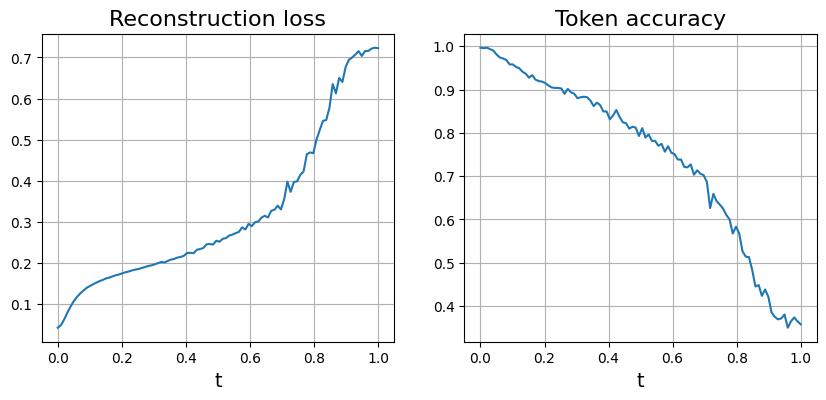

In [184]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(ts, losses)
plt.title('Reconstruction loss', size=16)
plt.xlabel('t', size=14)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(ts, accuracies)
plt.title('Token accuracy', size=16)
plt.xlabel('t', size=14)
plt.grid()

In [2]:
split = 'valid'
max_sequence_len = 50

In [3]:
from datasets import Dataset

In [43]:
def batch_preprocessing_conditional(batch):
    # Text encode
    batch = pd.DataFrame(batch).to_dict(orient="list")

    if split == 'train':
        swap_rate = 0.5
        blank_cond_rate = 0.1
    else:
        swap_rate = 0
        blank_cond_rate = 0

    if np.random.rand() < swap_rate:
        batch['text_trg'], batch['text_src'], batch['latent_trg'] = batch['text_src'], batch['text_trg'], batch['latent_src']

    input_ = tokenizer_gen(
        batch['text_trg'],
        add_special_tokens=True,
        padding="max_length",
        truncation=True,
        max_length=max_sequence_len,
        return_tensors="pt",
    )

    if np.random.rand() < blank_cond_rate:
        batch['text_src'] = [''] * len(batch['text_src'])

    cond_ = tokenizer_gen(
        batch['text_src'],
        add_special_tokens=True,
        padding=True,
        return_tensors="pt",
    )
    output = {
        "input_ids": input_["input_ids"],
        "cond_ids": cond_["input_ids"],
        "input_mask": input_["attention_mask"],
        "cond_mask": cond_["attention_mask"],
        "input_latent": batch['latent_trg'],
    }

    return output

In [41]:
new_dt = []
for i in tqdm(range(0, len(dt), 512)):
    output = batch_preprocessing_conditional(dt[i:i+512])
    keys = list(output.keys())
    list_output = []
    for i in range(len(output[keys[0]])):
        new_dict = {}
        for k in keys:
            new_dict[k] = output[k][i]

        list_output.append(new_dict)
    
    new_dt.extend(list_output)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
len(new_dt)

In [43]:
dt = Dataset.from_list(new_dt)

dt = dt.with_format("pt", columns=["input_ids", "cond_ids", "input_mask", "cond_mask", "input_latent"])  # , "cond_latent"])

In [17]:
dt

Dataset({
    features: ['text_src', 'text_trg', 'latent_src', 'latent_trg'],
    num_rows: 2047
})

In [44]:
valid_loader = DataLoader(
    dt,
    collate_fn=batch_preprocessing_conditional,
    batch_size=8,
    # num_workers=10,
    num_workers=0,
    pin_memory=True,
)

In [45]:
batch = next(iter(valid_loader))

In [47]:
batch.keys()

dict_keys(['input_ids', 'cond_ids', 'input_mask', 'cond_mask', 'input_latent'])

In [ ]:
batch['input_latent'][0][0]

In [58]:
c = torch.tensor(batch['input_latent'])

In [59]:
c.shape

torch.Size([8, 50, 768])

In [10]:
input_latent = batch['latent_trg']
input_latent = torch.stack([
    torch.stack(input_latent[i]) for i in range(len(input_latent))
]).permute(2, 0, 1)

In [12]:
tokenizer_gen = AutoTokenizer.from_pretrained('bert-base-uncased')

In [12]:
input_ = tokenizer_gen(
            batch['text_trg'],
            add_special_tokens=True,
            padding="max_length",
            truncation=True,
            max_length=50,
        )
